# Figures
Create some figures to include in slides for my talk.

In [136]:
import os
import sys

import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splev,splrep,splprep,interp1d
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from astropy.visualization import ImageNormalize,AsinhStretch,SqrtStretch
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.modeling
from sunpy.map import Map,GenericMap
import sunpy.coordinates
import sunpy

import synthesizAR
from synthesizAR.util import heeq_to_hcc_coord,read_xml
from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../../synthesized_timelag_maps/scripts/')
from timelags import AIATimeLags
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

In [3]:
rwb_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'rwb_nice', [(215/255, 48/255, 31/255), (1, 1, 1), (5/255, 112/255, 176/255)], N=1000)

## Magnetogram and Fieldlines

In [128]:
ar_base = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

Show the fieldlines overlaid on the magnetogram

In [62]:
def aiaprep(aiamap):
    # Target scale is 0.6 arcsec/pixel, but this needs to be adjusted if the map
    # has already been rescaled.
    if (aiamap.scale[0] / 0.6).round() != 1.0 * u.arcsec and aiamap.data.shape != (4096, 4096):
        scale = (aiamap.scale[0] / 0.6).round() * 0.6 * u.arcsec
    else:
        scale = 0.6 * u.arcsec  # pragma: no cover # can't test this because it needs a full res image
    scale_factor = aiamap.scale[0] / scale

    tempmap = aiamap.rotate(recenter=True, scale=scale_factor.value, missing=aiamap.min())

    # extract center from padded aiamap.rotate output
    # crpix1 and crpix2 will be equal (recenter=True), as aiaprep does not work with submaps
    center = np.floor(tempmap.meta['crpix1'])
    range_side = (center + np.array([-1, 1]) * aiamap.data.shape[0] / 2) * u.pix
    newmap = tempmap.submap(u.Quantity([range_side[0], range_side[0]]), u.Quantity([range_side[1], range_side[1]]))

    newmap.meta['r_sun'] = newmap.meta['rsun_obs'] / newmap.meta['cdelt1']
    newmap.meta['lvl_num'] = 1.5

    return newmap

In [63]:
# Get the smooth magnetogram
magnetogram = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/hmi/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits')
magnetogram = magnetogram.rotate(order=3)
magnetogram_prepped = aiaprep(magnetogram)
magnetogram = magnetogram.submap(
    SkyCoord(*u.Quantity([-440,-375],u.arcsec), frame=magnetogram.coordinate_frame),
    SkyCoord(*u.Quantity([-140,-75],u.arcsec), frame=magnetogram.coordinate_frame)
)
magnetogram_prepped = magnetogram_prepped.submap(
    SkyCoord(*u.Quantity([-440,-375],u.arcsec), frame=magnetogram_prepped.coordinate_frame),
    SkyCoord(*u.Quantity([-140,-75],u.arcsec), frame=magnetogram_prepped.coordinate_frame)
)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: Ru

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


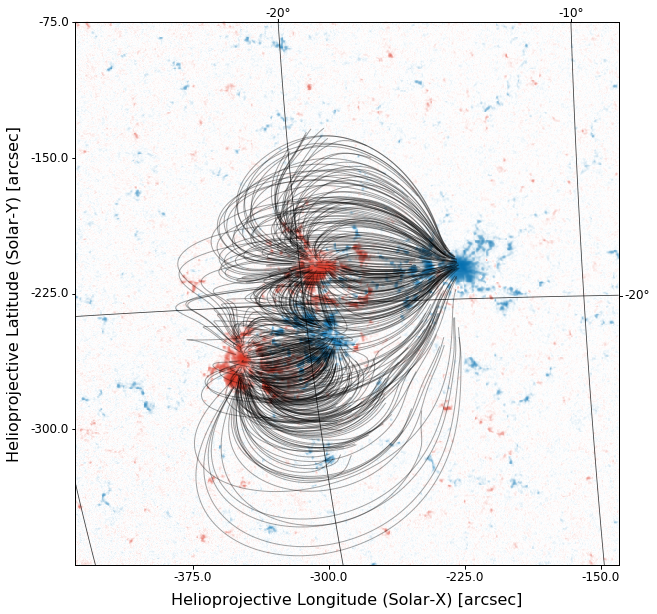

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection=magnetogram)
#ax.tick_params(axis='both',which='both',direction='in')
magnetogram.plot(axes=ax,title=False,cmap=rwb_cmap, 
                 norm=matplotlib.colors.SymLogNorm(100,vmin=-1.5e3,vmax=1.5e3))
ax.grid(alpha=0.)
hgs_grid = magnetogram.draw_grid(axes=ax, grid_spacing=10*u.deg, alpha=0.75, color='k')
for l in ar_base.loops[::10]:
    line = l.coordinates
    coord = (heeq_to_hcc_coord(line[:, 0], line[:, 1], line[:, 2], magnetogram.observer_coordinate)
             .transform_to(magnetogram.coordinate_frame))
    ax.plot_coord(coord, '-', color='k', lw=1,alpha=0.35)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_axislabel(lon.get_axislabel(),fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel(lat.get_axislabel(),fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
hgs_lon,hgs_lat = hgs_grid[0],hgs_grid[1]
hgs_lon.set_axislabel('')
hgs_lat.set_axislabel('')
hgs_lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
hgs_lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
fig.savefig('../img/magnetogram_plus_lines.png',dpi=300,bbox_inches='tight')

Now, overlay the fieldlines on a composite AIA image (171 + 211 + 131) to show that our traced fieldlines do a decent job of capturing the morphology of the AR.

In [9]:
aia_94 = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153350_94_cutout.fits')
aia_131 = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153345_131_cutout.fits')
aia_171 = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153348_171_cutout.fits')
aia_193 = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153355_193_cutout.fits')
aia_211 = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153348_211_cutout.fits')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


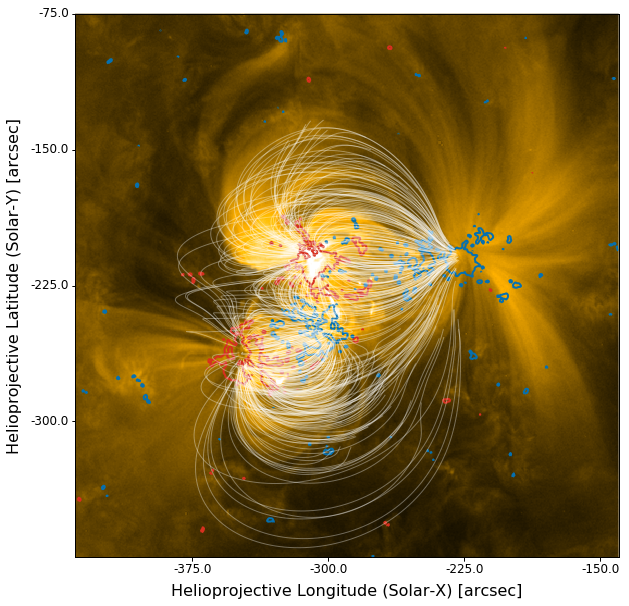

In [163]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=aia_171)
norm=ImageNormalize(vmin=0,vmax=5e3,stretch=AsinhStretch(0.1))
# 211
aia_171.plot(axes=ax,title=False,norm=norm)
# 193
#aia_193_masked = Map(
#    np.ma.masked_less_equal(aia_193.data,1e2),
#    aia_193.meta,
#)
#aia_193_masked.plot(axes=ax,title=False,norm=norm,alpha=0.55)
# 171
#aia_211_masked = Map(
#    np.ma.masked_less_equal(aia_211.data,1e2),
#    aia_211.meta
#)
#aia_211_masked.plot(axes=ax,title=False,norm=norm,alpha=0.65)
## 131
#aia_131_masked = Map(
#    np.ma.masked_less_equal(aia_131.data,1.5e1),
#    aia_131.meta,
#)
#aia_131_masked.plot(axes=ax,title=False,norm=norm,alpha=0.35)
# Draw HMI contours
#magnetogram_prepped = aiaprep(magnetogram)
magnetogram_prepped.draw_contours(
    u.Quantity([-10,10],u.percent),axes=ax,colors=((215/255, 48/255, 31/255),(5/255, 112/255, 176/255)),alpha=1.
)
ax.grid(alpha=0)
for l in ar_base.loops[::10]:
    line = l.coordinates
    coord = (heeq_to_hcc_coord(line[:, 0], line[:, 1], line[:, 2], magnetogram.observer_coordinate)
             .transform_to(magnetogram.coordinate_frame))
    ax.plot_coord(coord, '-', color='w', lw=1,alpha=0.35)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_axislabel(lon.get_axislabel(),fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel(lat.get_axislabel(),fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
fig.savefig('../img/131_plus_magnetogram_plus_lines.png',dpi=300,bbox_inches='tight')

Show the distribution of loop lengths

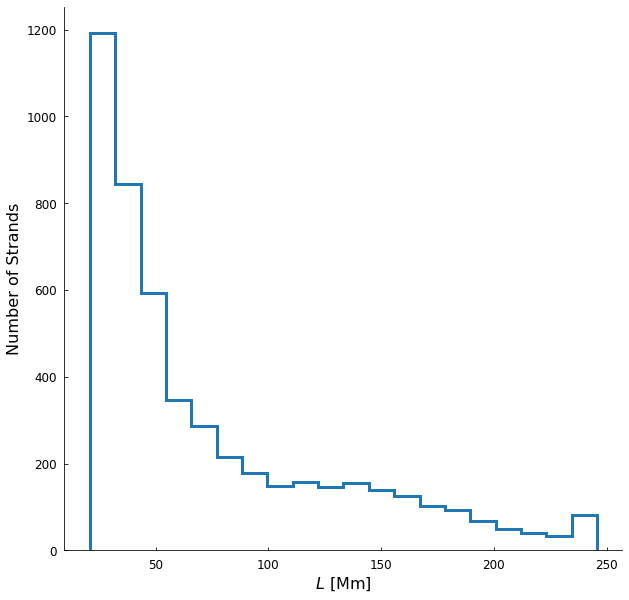

In [134]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.hist([loop.full_length.to(u.Mm).value for loop in ar_base.loops],histtype='step',lw=3,bins='scott',);
ax.set_xlabel(f'$L$ [{ar_base.loops[0].full_length.to(u.Mm).unit.to_string(format="latex")}]')
ax.set_ylabel(r'Number of Strands')
#ax.set_ylim(10,1300)
#ax.set_xlim(10,260)
ax.tick_params(which='both',axis='both',direction='in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_bounds(15,260)
#ax.spines['bottom'].set_position(('outward',3.))
#ax.spines['left'].set_bounds(100,1300)
#ax.spines['left'].set_position(('outward',3.))
#ax.set_yscale('log')
fig.savefig('../img/loop_length_distribution.png',format='png',dpi=300,bbox_inches='tight',transparent=True)

## Hydrodynamic Simulations
Plot $T$ and $n$ curves for our three heating cases

In [11]:
ar_high = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint/')
ar_intermediate = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/')
ar_low = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/field_checkpoint/')

In [12]:
i_loop = 6#np.random.randint(0,len(ar_base.loops),size=1)[0]

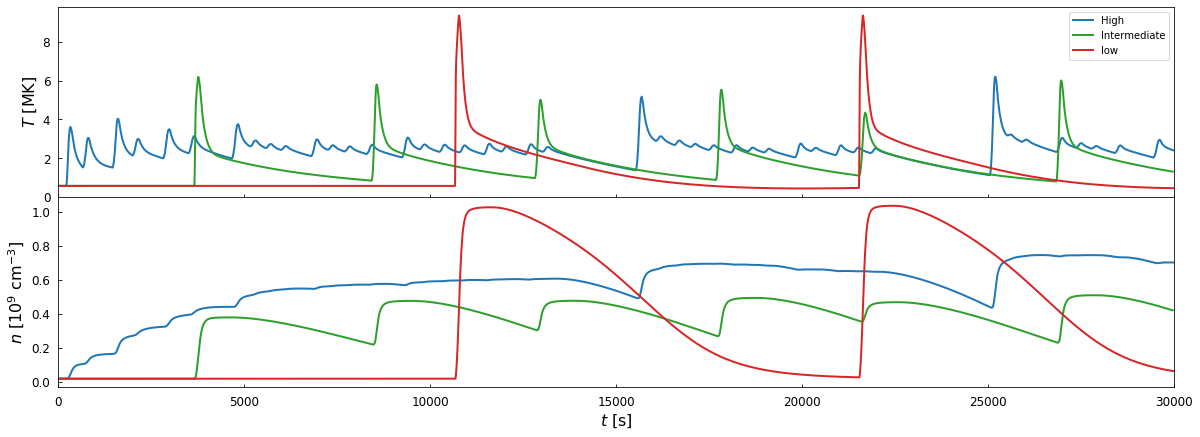

In [41]:
fig,axes = plt.subplots(2,1,figsize=(20,7),sharex=True)
# Temperature
axes[0].plot(ar_high.loops[i_loop].time,ar_high.loops[i_loop].electron_temperature[:,0].to(u.MK),color='C0',label='High')
axes[0].plot(ar_intermediate.loops[i_loop].time,ar_intermediate.loops[i_loop].electron_temperature[:,0].to(u.MK),color='C2',label='Intermediate')
axes[0].plot(ar_low.loops[i_loop].time,ar_low.loops[i_loop].electron_temperature[:,0].to(u.MK),color='C3',label='low')
axes[0].legend()
axes[0].tick_params(axis='both',which='both',direction='in')

# Density
axes[1].plot(ar_high.loops[i_loop].time,ar_high.loops[i_loop].density[:,0]/1e9,color='C0',)
axes[1].plot(ar_intermediate.loops[i_loop].time,ar_intermediate.loops[i_loop].density[:,0]/1e9,color='C2',)
axes[1].plot(ar_low.loops[i_loop].time,ar_low.loops[i_loop].density[:,0]/1e9,color='C3',)
axes[1].tick_params(axis='both',which='both',direction='in')
# Labels and limits
axes[0].set_xlim(0,3e4)
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')
# Adjustments
plt.subplots_adjust(hspace=0.)
fig.savefig('../img/temperature_density_profiles.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Heating Model

Plot the heating profiles for our three heating cases

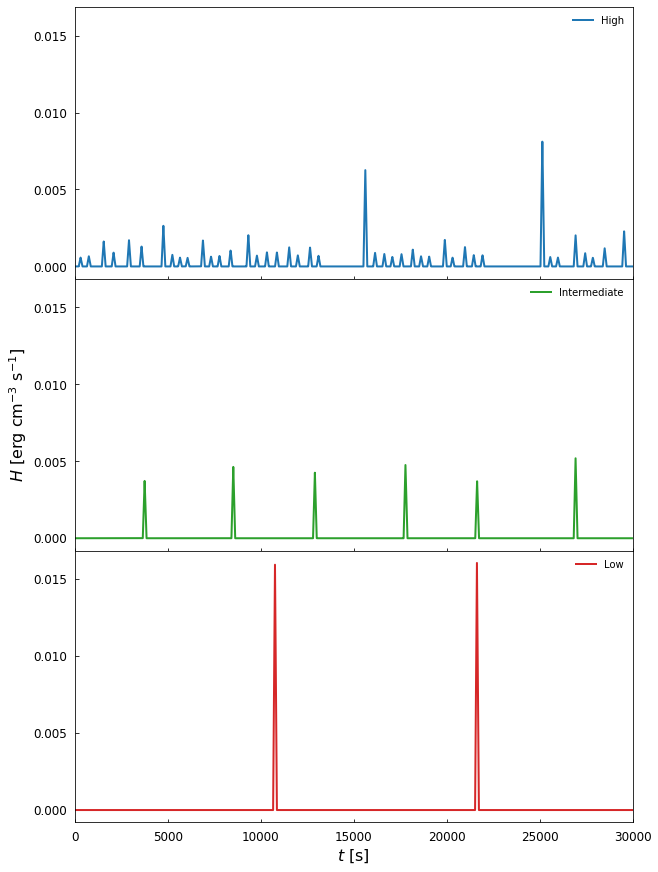

In [51]:
fig,axes = plt.subplots(3,1,figsize=(10,15),sharex=True,sharey=True)
# High
q = np.loadtxt(os.path.join(os.path.dirname(ar_high.loops[i_loop].parameters_savefile),f'hydro_results/{ar_high.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_high.loops[i_loop].time,q,color='C0',label='High')
# Intermediate
q = np.loadtxt(os.path.join(os.path.dirname(ar_intermediate.loops[i_loop].parameters_savefile),f'hydro_results/{ar_intermediate.loops[i_loop].name}'))[:,-1]
axes[1].plot(ar_intermediate.loops[i_loop].time,q,color='C2',label='Intermediate')
# Low
q = np.loadtxt(os.path.join(os.path.dirname(ar_low.loops[i_loop].parameters_savefile),f'hydro_results/{ar_low.loops[i_loop].name}'))[:,-1]
axes[2].plot(ar_low.loops[i_loop].time,q,color='C3',label='Low')
# Labels etc
axes[0].tick_params(axis='both',which='both',direction='in')
axes[1].tick_params(axis='both',which='both',direction='in')
axes[2].tick_params(axis='both',which='both',direction='in')
#axes[0].ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
axes[0].locator_params(axis='y',nbins=5)
axes[0].set_xlim(0,3e4)
axes[1].set_ylabel(r'$H$ [erg cm$^{-3}$ s$^{-1}$]')
axes[2].set_xlabel(r'$t$ [s]')
plt.subplots_adjust(hspace=0.)
axes[0].legend(frameon=False);
axes[1].legend(frameon=False);
axes[2].legend(frameon=False);
fig.savefig('../img/heating_profiles.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Intensities
~~Make a quick movie~~ Make plots of the intensities for 4/6 channels for all three nanoflare heating functions

In [81]:
path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}_frequency/nei/SDO_AIA/{}/map_t001500.fits'

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


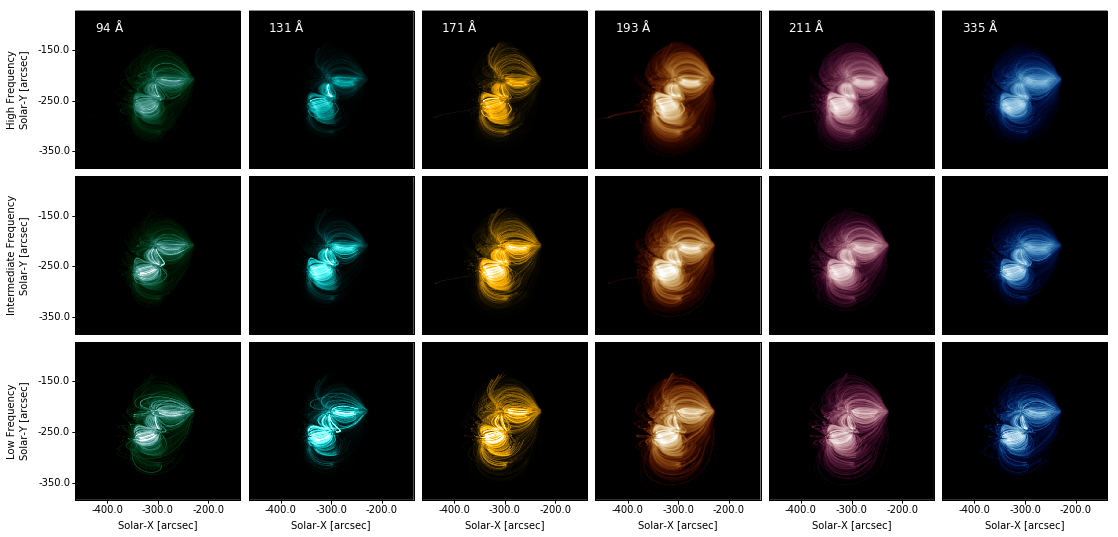

In [129]:
fig = plt.figure(figsize=(18.5,9))
vmax = {'94':5e1,'131':1e2,'171':1e3,'193': 1e3, '211': 1e3, '335':1e2}
for i,f in enumerate(['high','intermediate','low']):
    for j,c in enumerate(['94','131','171','193','211','335']):
        m = Map(path_format.format(f,c))
        ax = fig.add_subplot(3,6,6*i+j+1,projection=m)
        norm = ImageNormalize(vmin=0,vmax=vmax[c],stretch=AsinhStretch(0.01))
        m.plot(axes=ax,title=False,annotate=False,norm=norm)
        ax.grid(alpha=0)
        lon,lat = ax.coords[0],ax.coords[1]
        if i < 2:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        else:
            lon.set_ticks(values=([-400,-300,-200]*u.arcsec).to(u.deg))
            lon.set_axislabel('Solar-X [arcsec]')
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        else:
            lat.set_ticks(values=([-350,-250,-150]*u.arcsec).to(u.deg))
            lab = 'Solar-Y [arcsec]'
            lat.set_axislabel(f'{f.capitalize()} Frequency\n{lab}',minpad=2)
        if i == 0:
            xtext,ytext = m.world_to_pixel(SkyCoord(-425*u.arcsec, -115*u.arcsec, frame=m.coordinate_frame))
            ax.text(xtext.value,ytext.value,f'{c} $\mathrm{{\AA}}$',color='w',fontsize=plt.rcParams['xtick.labelsize'])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
fig.savefig('../img/aia_maps.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Timelag Analysis

In [231]:
aia = InstrumentSDOAIA([0,10000]*u.s)
aia.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA_counts.h5'
aia.observer_coordinate = aia_171.observer_coordinate
timelags_cooling = AIATimeLags(aia, '../../synthesized_timelag_maps/notebooks/intensity_maps_cooling.h5',)

In [139]:
xc,yc = -325*u.arcsec, -200*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

In [53]:
channel_pairs = [(94,335), (94,171), (335,211), (335,171), (193,171), (171,131)]

In [140]:
ts = {}
for channel in aia.channels:
    ts[channel['name']] = timelags_cooling.make_timeseries(channel['name'], lower_left_corner, upper_right_corner)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [147]:
cc = {}
for p in channel_pairs:
    cc['{}_{}'.format(*p)] = timelags_cooling.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


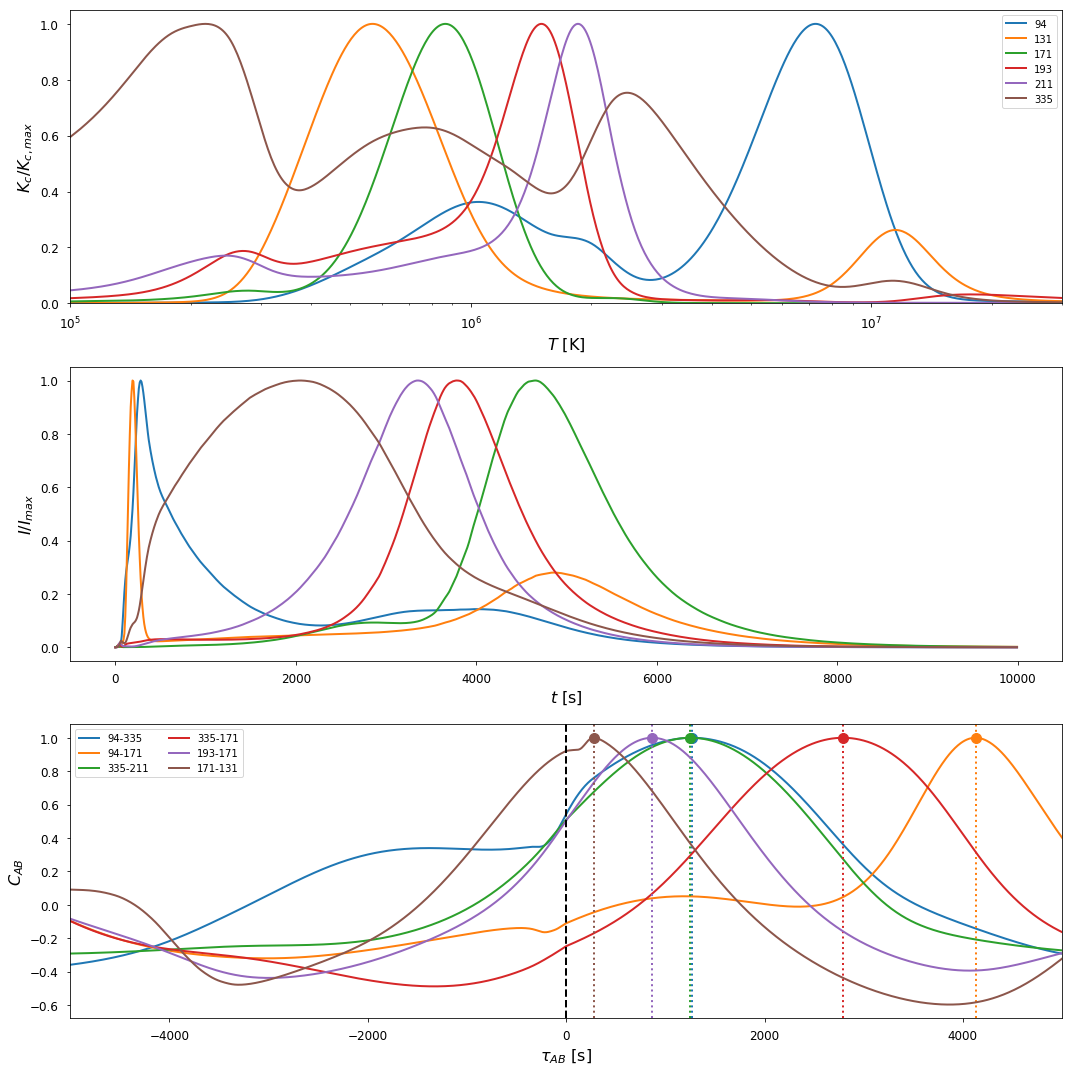

In [426]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(311)
t = np.logspace(4,8,1000)
for i,c in enumerate(aia.channels):
    kc = splev(t,c['temperature_response_spline'])
    ax.plot(t,kc/kc.max(),color=f'C{i}',label=c['name'])
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$T$ [K]');
ax.set_ylabel(r'$K_c/K_{c,max}$');
ax.set_ylim(0,1.05)
ax.set_xlim(1e5,3e7)
ax.legend(loc=1)
ax = fig.add_subplot(312)
for i,channel in enumerate(aia.channels):
    ax.plot(aia.observing_time,
            ts[channel['name']]/ts[channel['name']].max(),
            color=f'C{i}', label=f'{channel["name"]} $\mathrm{{\AA}}$')
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$I/I_{max}$')
#ax.legend()
ax = fig.add_subplot(313)
for i,p in enumerate(channel_pairs):
    cor = cc['{}_{}'.format(*p)]/cc['{}_{}'.format(*p)].max()
    ax.plot(timelags_cooling.timelags, cor, color=f'C{i}',ls='-',label='{}-{}'.format(*p))
    ax.plot(timelags_cooling.timelags[np.argmax(cor)],1,'o',color=f'C{i}',markersize=10)
    ax.axvline(x=timelags_cooling.timelags[np.argmax(cor)].value,color=f'C{i}',ls=':')
ax.axvline(x=0,ls='--',color='k')
ax.legend(loc=2,ncol=2)
ax.set_xlim(-5e3,5e3)
ax.set_xlabel(r'$\tau_{AB}$ [s]')
ax.set_ylabel(r'$C_{AB}$')
plt.tight_layout()
fig.savefig('../img/timeseries_timelags.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Timelag Maps
We'll choose only 3 channel pairs to show. These are channels which are well-separated in temperature space and have *mostly* single peaks.

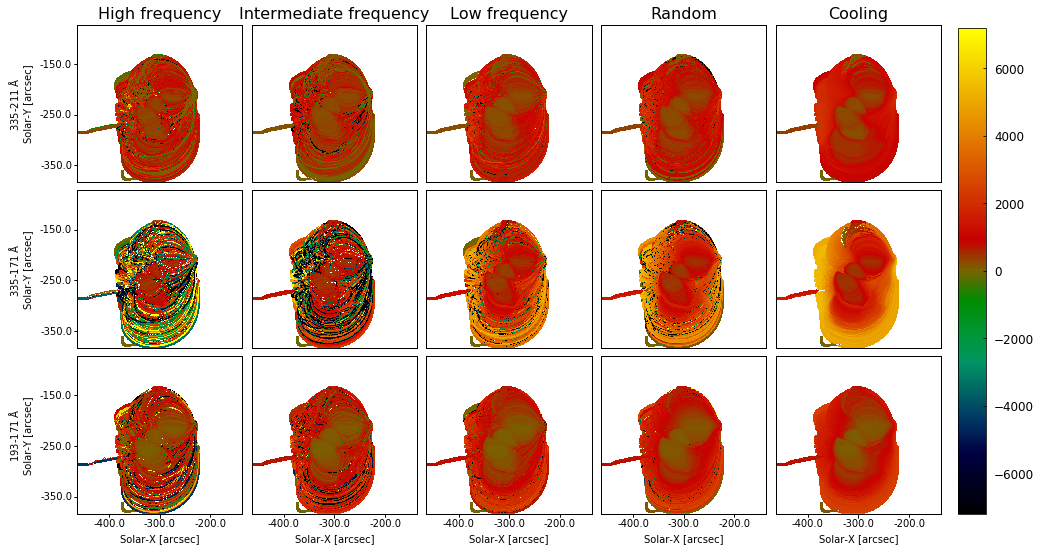

In [524]:
fig = plt.figure(figsize=(15.5,9))
cax = fig.add_axes([0.915, 0.125, 0.025, 0.75])
for i,cp in enumerate(channel_pairs[2:5]):
    for j,h in enumerate(['high_frequency','intermediate_frequency','low_frequency','cooling_outofphase','cooling',]):
        m_tl = Map('../data/timelag_{}_{}-{}.fits'.format(h,*cp))
        m_c = Map('../data/correlation_{}_{}-{}.fits'.format(h,*cp))
        data = np.where((m_c.data) < 500., np.nan, m_tl.data)
        m_tl = Map(data, m_tl.meta)
        ax = fig.add_subplot(3,5,5*i+j+1,projection=m_tl)
        im = m_tl.plot(axes=ax,title=False,annotate=False,
                  vmin=(-2*u.hour).to(u.s).value,vmax=(2*u.hour).to(u.s).value,
                  cmap=bgry_004_idl_cmap
                      )
        ax.grid(alpha=0)
        lon,lat = ax.coords[0],ax.coords[1]
        if i < 2:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        else:
            lon.set_ticks(values=([-400,-300,-200]*u.arcsec).to(u.deg))
            lon.set_axislabel('Solar-X [arcsec]')
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        else:
            lat.set_ticks(values=([-350,-250,-150]*u.arcsec).to(u.deg))
            lab = 'Solar-Y [arcsec]'
            lat.set_axislabel(f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$\n{lab}',minpad=2)
        if i == 0:
            if h != 'cooling_outofphase':
                ax.set_title(r'{}'.format(' '.join(h.split('_')).capitalize()))
            else:
                ax.set_title(r'Random')
fig.colorbar(im,cax=cax,pad=0.,)
cax.tick_params(direction='in')
plt.subplots_adjust(wspace=0.05,hspace=0.05)
fig.savefig('../img/timelag_maps.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

Also plot the observed timelag maps. These will go in the supplementary slides.

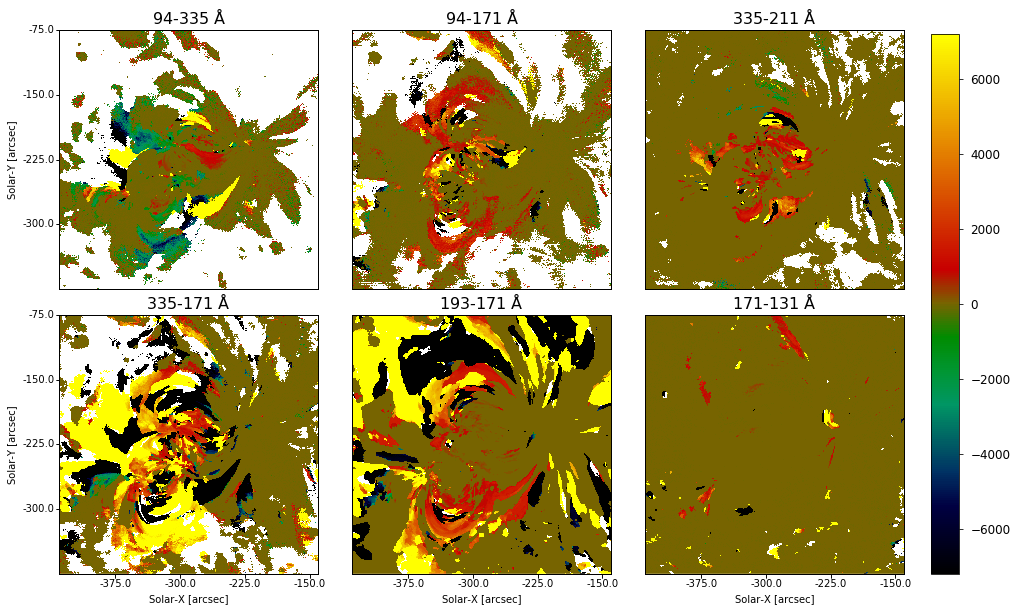

In [532]:
fig = plt.figure(figsize=(15.5,10))
cax = fig.add_axes([0.915, 0.125, 0.025, 0.75])
for i,cp in enumerate(channel_pairs):
    ### Timelag ###
    tmp = Map('../data/timelag_observed_{}-{}.fits'.format(*cp))
    #data = np.nan*np.ones(tmp.data.shape)
    #data[y_pixel,x_pixel] = tmp.data[y_pixel,x_pixel]
    #tmp = Map(data, tmp.meta)
    ### Correlation ###
    tmp_cor = Map('../data/correlation_observed_{}-{}.fits'.format(*cp))
    #data = np.zeros(tmp_cor.data.shape)
    #data[y_pixel,x_pixel] = tmp_cor.data[y_pixel,x_pixel]
    #tmp_cor = Map(data, tmp_cor.meta)
    # Remove low correlation values
    data = np.where((tmp_cor.data) < 500., np.nan, tmp.data)
    m = Map(data, tmp.meta)
    #m = observed_timelag_maps['{}-{}'.format(*cp)]
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(2*u.hour).to(u.s).value,
                vmax=(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Solar-Y [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Solar-X [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{} $\mathrm{{\AA}}$'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.05,hspace=0.1)
fig.savefig('../img/timelag_maps_observed.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Varying LOS

In [159]:
ar_base.magnetogram.meta['crval1']

-289.7650545917713

In [ ]:
fake_meta = {
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'cdelt1': 50,
    'cdelt2': 50,
    'crval1': 0,#ar_base.magnetogram.center.Tx.value,
    'crval2': 0,#ar_base.magnetogram.center.Ty.value,
    'crpix1': 5.5,
    'crpix2': 5.5,
    'dsun_ref': sunpy.sun.constants.au.value,
    'dsun_obs': sunpy.sun.constants.au.value,
    #'rsun_obs': ((sunpy.sun.constants.radius / sunpy.sun.constants.au)*u.radian).to(u.arcsec).value,
    'hgln_obs': ar_base.magnetogram.heliographic_longitude.to(u.deg).value,
    'hglt_obs': ar_base.magnetogram.heliographic_latitude.to(u.deg).value,
    'date_obs': '2017-01-01T00:00:00.00Z'
}
fake_map = sunpy.map.Map(np.nan*np.ones((10,10)),fake_meta)
foo_obs = SkyCoord(lon=fake_map.observer_coordinate.lon,lat=fake_map.observer_coordinate.lat,
                   radius=fake_map.observer_coordinate.radius,
                   frame=fake_map.observer_coordinate.frame)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=fake_map)
p = fake_map.plot(axes=ax,title=False,annotate=False)
hgs_grid = fake_map.draw_grid(color='k',lw=1)
hgs_grid[0].set_ticks_visible(False)
hgs_grid[0].set_ticklabel_visible(False)
hgs_grid[1].set_ticks_visible(False)
hgs_grid[1].set_ticklabel_visible(False)
for l in ar_base.loops[::50]:
    coord = heeq_to_hcc_coord(l.coordinates[:,0],l.coordinates[:,1],l.coordinates[:,2],fake_map.observer_coordinate)
    coord = coord.transform_to(sunpy.coordinates.Helioprojective(observer=fake_map.observer_coordinate))
    ax.plot_coord(coord,lw=1,color='C3',alpha=0.85)
# Ray 1
r1 = SkyCoord(lat=[ar_base.magnetogram.observer_coordinate.lat,
                   ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lat],
              lon=[ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lon - 90 * u.deg,
                   ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lon],
              radius=[ar_base.magnetogram.observer_coordinate.radius,
                      ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').radius],
              frame='heliographic_stonyhurst')
ax.plot_coord(r1,lw=3,color='C1')
# Ray 2
r2 = SkyCoord(lat=[ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lat+90*u.deg,
                   ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lat],
              lon=[ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lon,
                   ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lon],
              radius=[ar_base.magnetogram.observer_coordinate.radius,
                      ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').radius],
              frame='heliographic_stonyhurst')
ax.plot_coord(r2,lw=3,color='C2')
# Ray 3
r3 = SkyCoord(lat=[ar_base.magnetogram.observer_coordinate.lat,
                   ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lat],
              lon=[ar_base.magnetogram.observer_coordinate.lon,
                   ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').lon],
              radius=[ar_base.magnetogram.observer_coordinate.radius,
                      ar_base.magnetogram.center.transform_to('heliographic_stonyhurst').radius],
              frame='heliographic_stonyhurst')
#ax.plot_coord(r3,lw=3,color='C0')
lon,lat = ax.coords[0],ax.coords[1]
lon.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lat.set_ticks_visible(False)
lon.frame.set_linewidth(0.)
lat.frame.set_linewidth(0.)
fig.savefig('../img/viewing_angle_cartoon.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

Plot intensity maps for varying LOS angle for all 6 channels at $t=1.5\times10^3$ s. This will go in the supplementary figures.

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


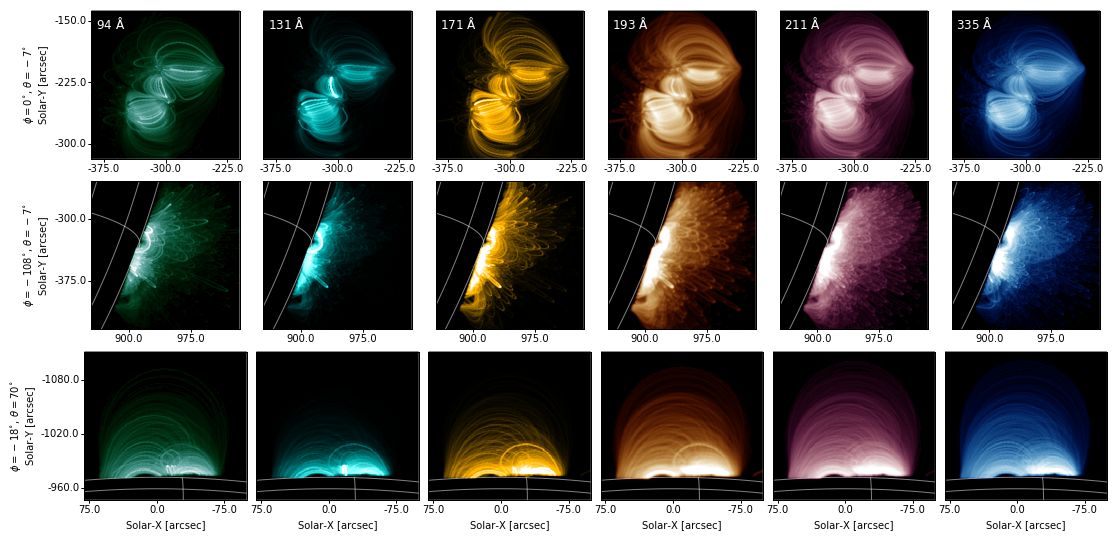

In [87]:
los_path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/{}SDO_AIA/{}/map_t001500.fits'
fig = plt.figure(figsize=(18.5,9))
vmax = {'94':5e1,'131':1e2,'171':1e3,'193': 1e3, '211': 1e3, '335':1e2}
for i,f in enumerate(['','off_limb/','arcade/',]):
    for j,c in enumerate(['94','131','171','193','211','335']):
        m = Map(los_path_format.format(f,c))
        if f == 'arcade/':
            m = m.rotate(180*u.deg)
        blc = SkyCoord(m.center.Tx - 90*u.arcsec,m.center.Ty - 90*u.arcsec,frame=m.coordinate_frame)
        trc = SkyCoord(m.center.Tx + 90*u.arcsec,m.center.Ty + 90*u.arcsec,frame=m.coordinate_frame)
        m = m.submap(blc,trc)
        ax = fig.add_subplot(3,6,6*i+j+1,projection=m)
        norm = ImageNormalize(vmin=0,vmax=vmax[c],stretch=AsinhStretch(0.01))
        m.plot(axes=ax,title=False,annotate=False,norm=norm)
        #m.draw_limb(axes=ax,color='w',lw=1)
        if f == 'off_limb/' or f == 'arcade/':
            hgs_grid = m.draw_grid(axes=ax,grid_spacing=10*u.deg,color='w',lw=1)
            hgs_grid[0].set_ticks_visible(False)
            hgs_grid[0].set_ticklabel_visible(False)
            hgs_grid[0].set_axislabel('')
            hgs_grid[1].set_ticks_visible(False)
            hgs_grid[1].set_ticklabel_visible(False)
            hgs_grid[1].set_axislabel('')
        ax.grid(alpha=0)
        lon,lat = ax.coords[0],ax.coords[1]
        lon.set_ticks(number=3)
        if i == 2:
            #lon.set_ticks(values=([-400,-300,-200]*u.arcsec).to(u.deg))
            lon.set_axislabel('Solar-X [arcsec]')
        if j == 0:
            #lat.set_ticks(values=([-350,-250,-150]*u.arcsec).to(u.deg))
            lab = 'Solar-Y [arcsec]'
            los_lab = r"$\phi={phi:.0f}^{{\circ}}$, $\Theta={theta:.0f}^{{\circ}}$".format(phi=m.meta['hgln_obs'],theta=m.meta['hglt_obs'])
            lat.set_axislabel(f'{los_lab.capitalize()}\n{lab}',minpad=2)
            lat.set_ticks(number=3)
        else:
            lat.set_ticks_visible(False)
            lat.set_ticklabel_visible(False)
        if i == 0:
            xtext,ytext = m.world_to_pixel(SkyCoord(-385*u.arcsec, -160*u.arcsec, frame=m.coordinate_frame))
            ax.text(xtext.value,ytext.value,f'{c} $\mathrm{{\AA}}$',color='w',fontsize=plt.rcParams['xtick.labelsize'])
plt.subplots_adjust(wspace=0.,hspace=0.15)
fig.savefig('../img/aia_maps_varying_los.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

Plot timelag maps for the various LOS angles

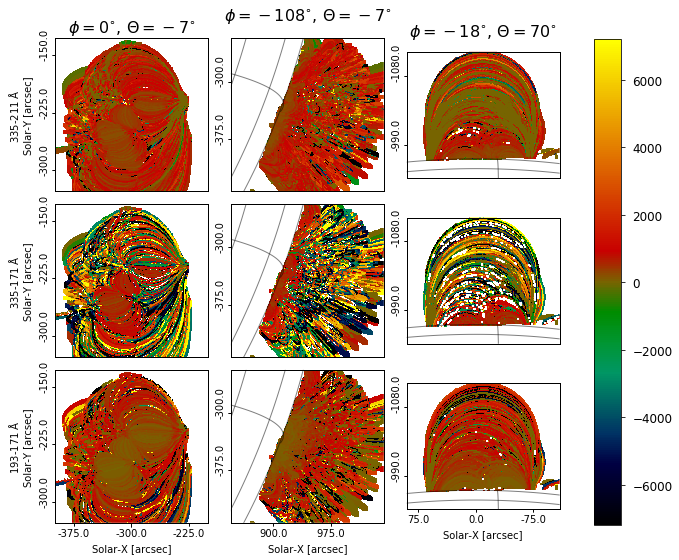

In [112]:
fig = plt.figure(figsize=(18.5,9))
cax = fig.add_axes([0.53, 0.125, 0.02, 0.75])
vmax = {'94':5e1,'131':1e2,'171':1e3,'193': 1e3, '211': 1e3, '335':1e2}
for j,f in enumerate(['high_frequency','off_limb','arcade',]):
    for i,cp in enumerate(channel_pairs[2:5]):
        m = Map('../data/timelag_{}_{}-{}.fits'.format(f,*cp))
        m_cor = Map('../data/correlation_{}_{}-{}.fits'.format(f,*cp))
        m = Map(np.where(m_cor.data < 500., np.nan, m.data),m.meta)
        if f == 'arcade':
            m = m.rotate(180*u.deg,order=3)
        blc = SkyCoord(m.center.Tx - 100*u.arcsec,m.center.Ty - 100*u.arcsec,frame=m.coordinate_frame)
        trc = SkyCoord(m.center.Tx + 100*u.arcsec,m.center.Ty + 100*u.arcsec,frame=m.coordinate_frame)
        m = m.submap(blc,trc)
        ax = fig.add_subplot(3,6,6*i+j+1,projection=m)
        norm = ImageNormalize(vmin=0,vmax=vmax[c],stretch=AsinhStretch(0.01))
        im = m.plot(axes=ax,title=False,annotate=False,
                  vmin=(-2*u.hour).to(u.s).value,vmax=(2*u.hour).to(u.s).value,
                  cmap=bgry_004_idl_cmap)
        #m.draw_limb(axes=ax,color='k',lw=1)
        if f == 'off_limb' or f == 'arcade':
            hgs_grid = m.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k',lw=1)
            hgs_grid[0].set_ticks_visible(False)
            hgs_grid[0].set_ticklabel_visible(False)
            hgs_grid[0].set_axislabel('')
            hgs_grid[1].set_ticks_visible(False)
            hgs_grid[1].set_ticklabel_visible(False)
            hgs_grid[1].set_axislabel('')
        ax.grid(alpha=0)
        lon,lat = ax.coords[0],ax.coords[1]
        lat.set_ticks(number=2 if f == 'arcade' else 3)
        lat.set_ticklabel(rotation='vertical')
        if i == 2:
            #lon.set_ticks(values=([-400,-300,-200]*u.arcsec).to(u.deg))
            lon.set_axislabel('Solar-X [arcsec]')
            lon.set_ticks(number=3)
        else:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j == 0:
            #lat.set_ticks(values=([-350,-250,-150]*u.arcsec).to(u.deg))
            lab = 'Solar-Y [arcsec]'
            lat.set_axislabel(f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$\n{lab}',minpad=2)
        if i == 0:
            ax.set_title(r"$\phi={phi:.0f}^{{\circ}}$, $\Theta={theta:.0f}^{{\circ}}$".format(phi=m.meta['hgln_obs'],theta=m.meta['hglt_obs']))
fig.colorbar(im,cax=cax)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
fig.savefig('../img/timelag_maps_varying_los.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

Plot timelag distributions for the selected channel pairs. In each panel, overlay the three LOS cases.

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


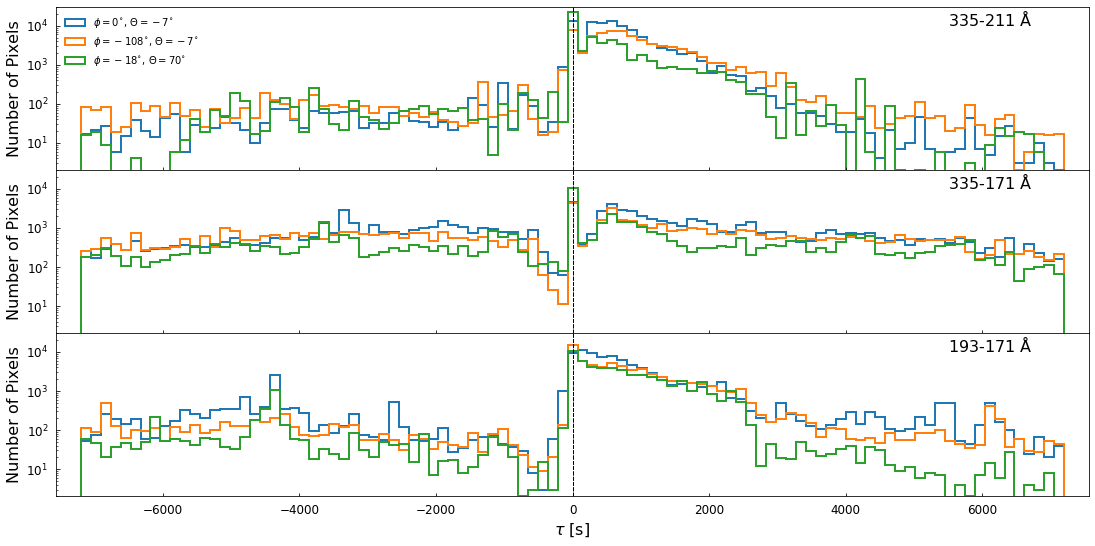

In [172]:
bins = np.linspace(-(2*u.hour).to(u.s).value, (2*u.hour).to(u.s).value, 100)
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'normed':False,'cumulative':False,'alpha':1.}
fig,axes = plt.subplots(3,1,figsize=(18.5,9),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.0,wspace=0.05)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for j,h in enumerate(['high_frequency','off_limb','arcade',]):
    for i,cp in enumerate(channel_pairs[2:5]):
        ax = axes[i]
        m_tl = Map('../data/timelag_{}_{}-{}.fits'.format(h,*cp))
        m_c = Map('../data/correlation_{}_{}-{}.fits'.format(h,*cp))
        data = m_tl.data.flatten()
        data_cor = m_c.data.flatten()
        dist = data[np.where(data_cor >= 500.)]
        lab = r"$\phi={phi:.0f}^{{\circ}}$, $\Theta={theta:.0f}^{{\circ}}$".format(
            phi=m_tl.meta['hgln_obs'],theta=m_tl.meta['hglt_obs'])
        ax.hist(dist, **params, color=f'C{j}',ls='-',label=lab)
        ax.axvline(x=0,ls='--',color='k',lw=1)
        ax.tick_params(axis='both',which='both',direction='in')
        if j == 0:
            ax.text(5500,1e4,f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$',fontsize=plt.rcParams['axes.labelsize'])
        if i == 0:
            ax.legend(loc=2,frameon=False)
        ax.set_ylabel('Number of Pixels')
        if i == 2:
            ax.set_xlabel(r'$\tau$ [s]')
axes[0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0].set_ylim(2,3e4);
fig.savefig('../img/timelag_distributions_varying_los.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Timelag Distributions
Show distributions with and without the observational results (and the KS statistic)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


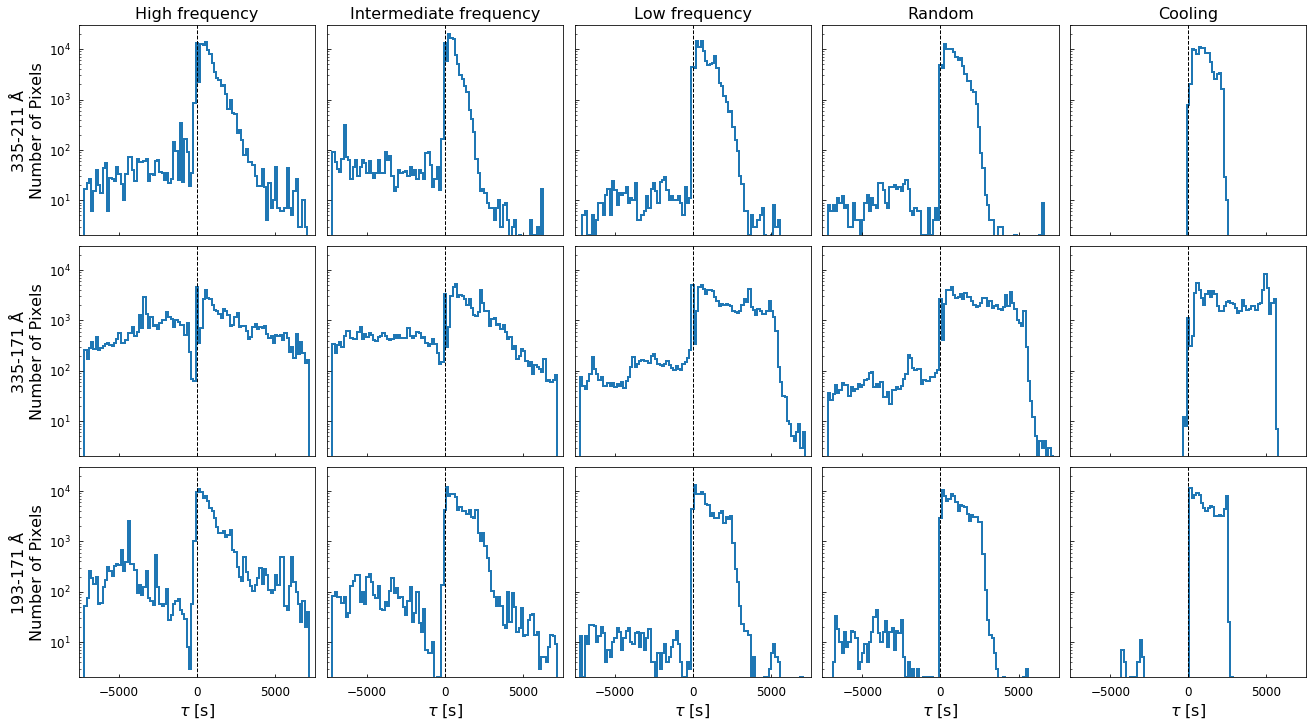

In [213]:
bins = np.linspace(-(2*u.hour).to(u.s).value, (2*u.hour).to(u.s).value, 100)
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'normed':False,'cumulative':False}
fig,axes = plt.subplots(3,5,figsize=(22,12),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for j,h in enumerate(['high_frequency','intermediate_frequency','low_frequency','cooling_outofphase','cooling',]):
    for i,cp in enumerate(channel_pairs[2:5]):
        ax = axes[i,j]
        m_tl = Map('../data/timelag_{}_{}-{}.fits'.format(h,*cp))
        m_c = Map('../data/correlation_{}_{}-{}.fits'.format(h,*cp))
        data = m_tl.data.flatten()
        data_cor = m_c.data.flatten()
        dist = data[np.where(data_cor >= 500.)]
        ax.hist(dist, **params, color='C0',ls='-',)
        ax.axvline(x=0,ls='--',color='k',lw=1)
        ax.tick_params(axis='both',which='both',direction='in')
        if j == 0:
            ax.set_ylabel(f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$\nNumber of Pixels')
        if i == 2:
            ax.set_xlabel(r'$\tau$ [s]')
        if i == 0:
            title_lab = 'Random' if h=='cooling_outofphase' else ' '.join(h.split('_')).capitalize()
            ax.set_title(title_lab)
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_ylim(2,3e4);
fig.savefig('../img/timelag_distributions.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

We want to find the pixel coordinates in the real map which correspond to the pixels we actually simulate.

In [232]:
core_pixels = m.world_to_pixel(aia.total_coordinates.transform_to(aia_171.coordinate_frame))

In [233]:
x_pixel = core_pixels.x.value.round().astype(int)
y_pixel = core_pixels.y.value.round().astype(int)
i_inbounds = np.where(np.logical_and(x_pixel>=0, y_pixel>=0))
x_pixel = x_pixel[i_inbounds]
y_pixel = y_pixel[i_inbounds]

Now plot the modeled and observed distributions and compute a distance metric between them.

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


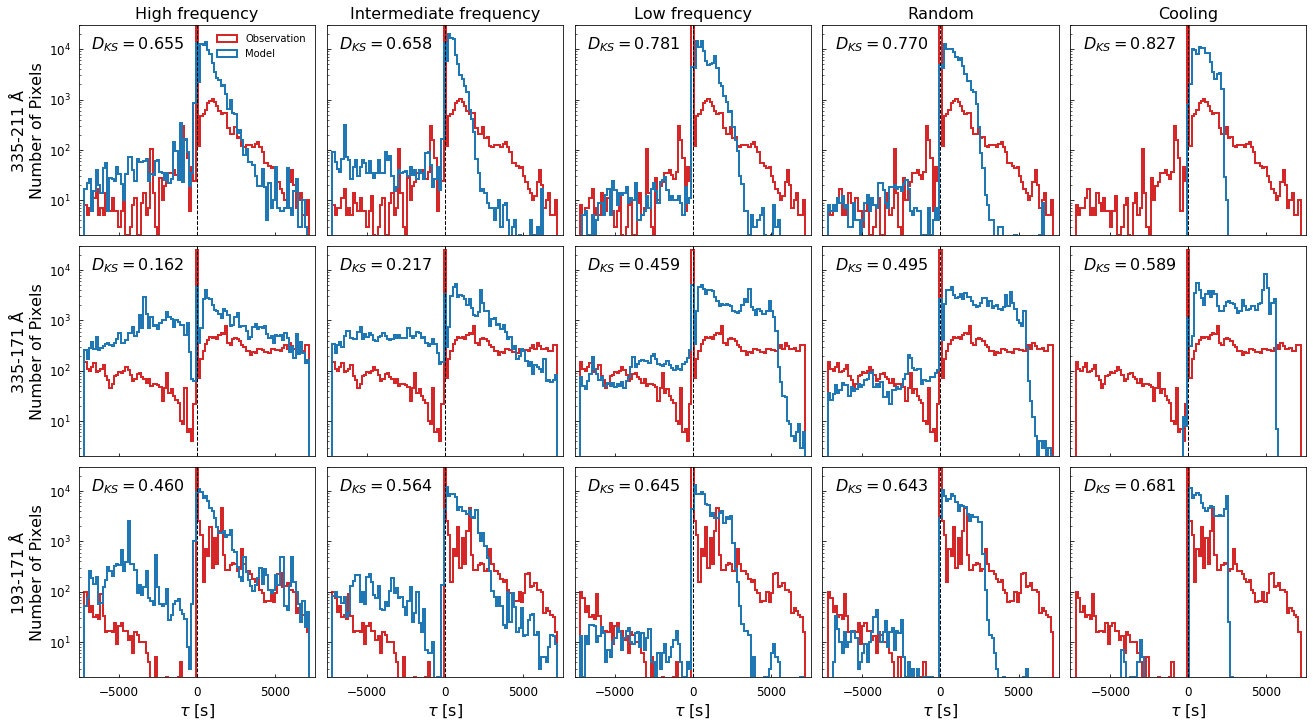

In [239]:
bins = np.linspace(-(2*u.hour).to(u.s).value, (2*u.hour).to(u.s).value, 100)
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'normed':False,'cumulative':False}
fig,axes = plt.subplots(3,5,figsize=(22,12),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for j,h in enumerate(['high_frequency','intermediate_frequency','low_frequency','cooling_outofphase','cooling',]):
    for i,cp in enumerate(channel_pairs[2:5]):
        ax = axes[i,j]
        # Observed
        m_tl = Map('../data/timelag_observed_{}-{}.fits'.format(*cp))
        mask = np.nan * np.ones(m_tl.data.shape)
        mask[y_pixel,x_pixel] = m_tl.data[y_pixel,x_pixel]
        m_tl = Map(mask,m_tl.meta)
        m_c = Map('../data/correlation_observed_{}-{}.fits'.format(*cp))
        mask = np.nan * np.ones(m_c.data.shape)
        mask[y_pixel,x_pixel] = m_c.data[y_pixel,x_pixel]
        m_c = Map(mask,m_c.meta)
        data = m_tl.data.flatten()
        data_cor = m_c.data.flatten()
        data = data[~np.isnan(data_cor)]
        data_cor = data_cor[~np.isnan(data_cor)]
        dist_obs = data[np.where(data_cor >= 500.)]
        ax.hist(dist_obs, **params, color='C3',ls='-',label='Observation')
        # Modeled
        m_tl = Map('../data/timelag_{}_{}-{}.fits'.format(h,*cp))
        m_c = Map('../data/correlation_{}_{}-{}.fits'.format(h,*cp))
        data = m_tl.data.flatten()
        data_cor = m_c.data.flatten()
        dist_model = data[np.where(data_cor >= 500.)]
        ax.hist(dist_model, **params, color='C0',ls='-',label='Model')
        ax.axvline(x=0,ls='--',color='k',lw=1)
        # Metric
        ks_d,ks_p = scipy.stats.ks_2samp(dist_obs, dist_model)
        ax.text(-6.75e3, 1e4, f'$D_{{KS}}={ks_d:.3f}$',fontsize=plt.rcParams['axes.labelsize'])
        # Ticks and Labels
        ax.tick_params(axis='both',which='both',direction='in')
        if j == 0:
            ax.set_ylabel(f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$\nNumber of Pixels')
        if i == 2:
            ax.set_xlabel(r'$\tau$ [s]')
        if i == 0:
            title_lab = 'Random' if h=='cooling_outofphase' else ' '.join(h.split('_')).capitalize()
            ax.set_title(title_lab)
        if i == 0 and j == 0:
            ax.legend(loc=0,frameon=False)
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_ylim(2,3e4);
fig.savefig('../img/timelag_distributions_plus_obs.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Cooling Time Analysis
We want to create a map of the loop lengths over the whole AR. We need to create a list of loop lengths, the same length as the total coordinates, with the loop lengths placed in the correct place.

In [348]:
ds = 0.5 * u.Mm
loop_lengths_flat = np.zeros(aia.total_coordinates.shape)
field_strength_flat = np.zeros(aia.total_coordinates.shape)
counter = 0
for loop in ar_base.loops:
    n = int(np.ceil((loop.full_length/ds).decompose()))
    # Loop length
    loop_lengths_flat[counter:counter+n] = loop.full_length.to(u.cm).value
    # B-field Strength
    interpolated_s = np.linspace(loop.field_aligned_coordinate.value[0], loop.field_aligned_coordinate.value[-1], n)
    #interpolated_b = interp1d(loop.field_aligned_coordinate.value,loop.field_strength.value)(interpolated_s)
    field_strength_flat[counter:counter+n] = loop.field_strength.mean().value#interpolated_b
    # Counter
    counter += n
hpc_coordinates = aia.total_coordinates
bins,bin_range = aia.make_detector_array(ar_base)

In [489]:
def cooling_time(loop_length, field_strength, channel_a,channel_b):
    # Compute half length
    half_length = loop_length/2.
    # Compute heating rate
    average_heating_rate_max = ((field_strength)**2)/8./np.pi/(200./2.)#*u.erg/(u.cm**3)/u.s
    # Find temperature at which channel response is max
    t_log = np.logspace(np.log10(4e5),np.log10(3e7),500)
    rsp = splev(t_log,channel_a['temperature_response_spline'])
    T_a = t_log[np.argmax(rsp)]
    rsp = splev(t_log,channel_b['temperature_response_spline'])
    T_b = t_log[np.argmax(rsp)]
    #print(f"{channel['name']}: {T0/1e6}")
    # set some constants
    alpha = -2/3
    chi = 6e-20#*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
    kappa_0 = 1e-6#*(u.erg/u.cm/u.s*(u.K**(-7/2)))
    c1,c2,c3 = 2.0,0.9,0.6
    gamma = 5./3.
    # estimate max n0T0
    #T0 = c2*(7.*half_length**2*average_heating_rate_max/2./kappa_0)**(2./7.)
    top_term = average_heating_rate_max - 2.*kappa_0*(T_a**(3.5))/(7.*(c2**2.5)*c3*(half_length**2)*gamma)
    bottom_term = c1*chi*(T_a**alpha)*(1. - c2/c3/gamma)
    n0 = np.sqrt(top_term/bottom_term)
    #n0 = (T_a**2) / ((1.4e3)**3 * 2. * const.k_B * half_length)
    p_a = n0*T_a
    top_term = average_heating_rate_max - 2.*kappa_0*(T_b**(3.5))/(7.*(c2**2.5)*c3*(half_length**2)*gamma)
    bottom_term = c1*chi*(T_b**alpha)*(1. - c2/c3/gamma)
    n0 = np.sqrt(top_term/bottom_term)
    #n0 = (T_b**2) / ((1.4e3)**3 * 2. * const.k_B * half_length)
    p_b = n0*T_b
    # Cargill cooling expression
    term1 = (2. - alpha)/(1. - alpha)
    term2 = (kappa_0**(4. - 2.*alpha))*(chi**7)
    term3 = ((half_length)**(8. - 4.*alpha))
    c_const = term1*3.*const.k_B.cgs.value*(1/term2*term3)**(1/(11. - 2.*alpha))
    return (p_a - p_b) * (3 + 2*alpha) / (11 - 2*alpha) * c_const * (p_a)**(-14/(11-2*alpha))

In [511]:
cooling_time_maps = {}
for cp in channel_pairs:
    cnames = [c['name'] for c in aia.channels]
    channel_a = aia.channels[cnames.index(f'{cp[0]}')]
    channel_b = aia.channels[cnames.index(f'{cp[1]}')]
    header = aia.make_fits_header(ar_base, channel_a)
    visible = synthesizAR.util.is_visible(hpc_coordinates, aia.observer_coordinate)
    hist_unweighted, _, _ = np.histogram2d(hpc_coordinates.Tx.value, hpc_coordinates.Ty.value,
                                bins=(bins.x.value, bins.y.value),
                                range=(bin_range.x.value, bin_range.y.value),)
    # Loop length
    hist, _, _ = np.histogram2d(hpc_coordinates.Tx.value, hpc_coordinates.Ty.value,
                                bins=(bins.x.value, bins.y.value),
                                range=(bin_range.x.value, bin_range.y.value),
                                weights=visible * loop_lengths_flat)
    hist /= np.where(hist_unweighted == 0, 1, hist_unweighted)
    hist = gaussian_filter(hist.T, (channel_a['gaussian_width']['y'].value, channel_a['gaussian_width']['x'].value))
    loop_length_map = GenericMap(hist, header)
    # Field strength
    hist, _, _ = np.histogram2d(hpc_coordinates.Tx.value, hpc_coordinates.Ty.value,
                                bins=(bins.x.value, bins.y.value),
                                range=(bin_range.x.value, bin_range.y.value),
                                weights=visible * field_strength_flat)
    hist /= np.where(hist_unweighted == 0, 1, hist_unweighted)
    hist = gaussian_filter(hist.T, (channel_a['gaussian_width']['y'].value,channel_a['gaussian_width']['x'].value))
    field_strength_map = GenericMap(hist, header)
    # Compute cooling time
    cooling_time_flat = cooling_time(loop_lengths_flat,field_strength_flat,channel_a,channel_b)
    #print(cooling_time_flat[np.isnan(cooling_time_flat)].shape)
    hist, _, _ = np.histogram2d(hpc_coordinates.Tx.value, hpc_coordinates.Ty.value,
                                bins=(bins.x.value, bins.y.value),
                                range=(bin_range.x.value, bin_range.y.value),
                                weights=visible * cooling_time_flat)
    hist /= np.where(hist_unweighted == 0, 1, hist_unweighted)
    hist = gaussian_filter(hist.T, (channel_a['gaussian_width']['y'].value,channel_a['gaussian_width']['x'].value))
    hist[hist_unweighted.T == 0] = np.nan
    cooling_time_maps['{}-{}'.format(*cp)] = GenericMap(hist,header)

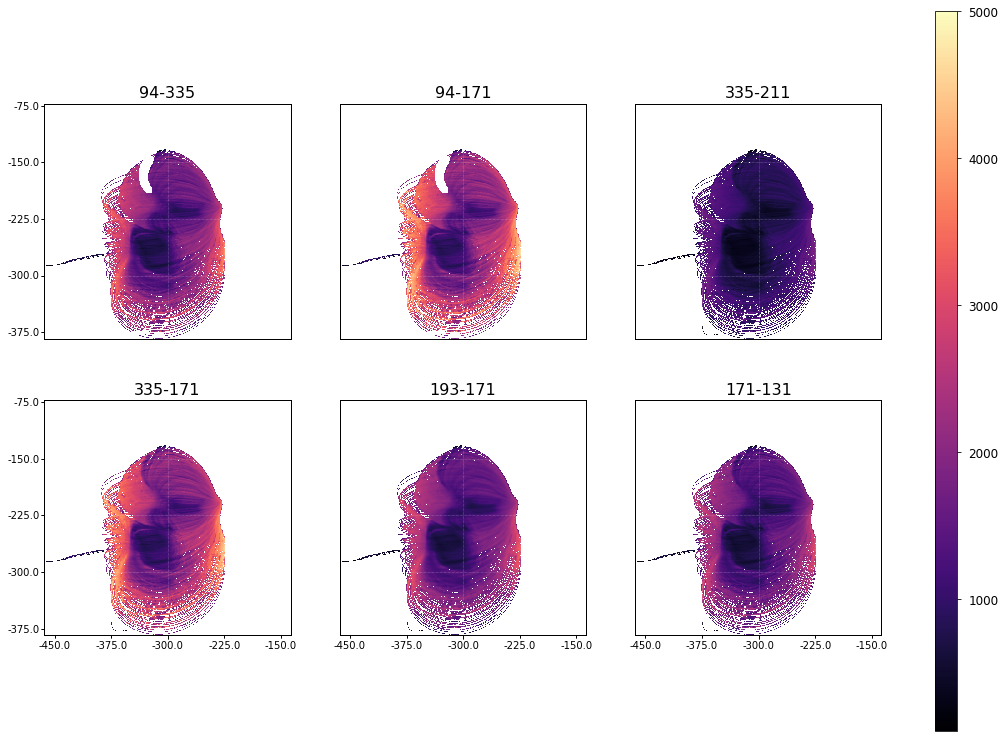

In [512]:
fig = plt.figure(figsize=(15,10))
cax = fig.add_axes([0.95,0.,0.02,1])
for i,cp in enumerate(channel_pairs):
    ax = fig.add_subplot(2,3,i+1,projection=cooling_time_maps['{}-{}'.format(*cp)])
    im = cooling_time_maps['{}-{}'.format(*cp)].plot(axes=ax,title=False,cmap='magma',annotate=False,
                                                     #norm=matplotlib.colors.SymLogNorm(1e-10,vmin=10,vmax=3e4,)
                                                     vmin=100,vmax=5e3)
    ax.set_title('{}-{}'.format(*cp))
    if i%3 != 0:
        ax.coords[1].set_ticks_visible(False)
        ax.coords[1].set_ticklabel_visible(False)
    if i < 3:
        ax.coords[0].set_ticks_visible(False)
        ax.coords[0].set_ticklabel_visible(False)
fig.colorbar(im,cax=cax)
#plt.tight_layout()

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


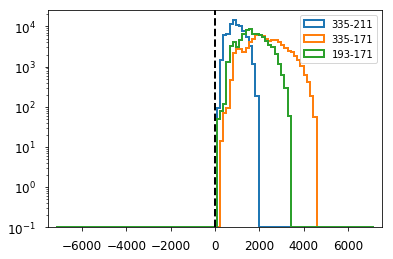

In [513]:
for cp in channel_pairs[2:5]:
    foo = cooling_time_maps['{}-{}'.format(*cp)].data.flatten()
    foo = foo[~np.isnan(foo)]
    plt.hist(foo,**params,label='{}-{}'.format(*cp));
plt.xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value)
plt.axvline(x=0,ls='--',color='k')
plt.legend()

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


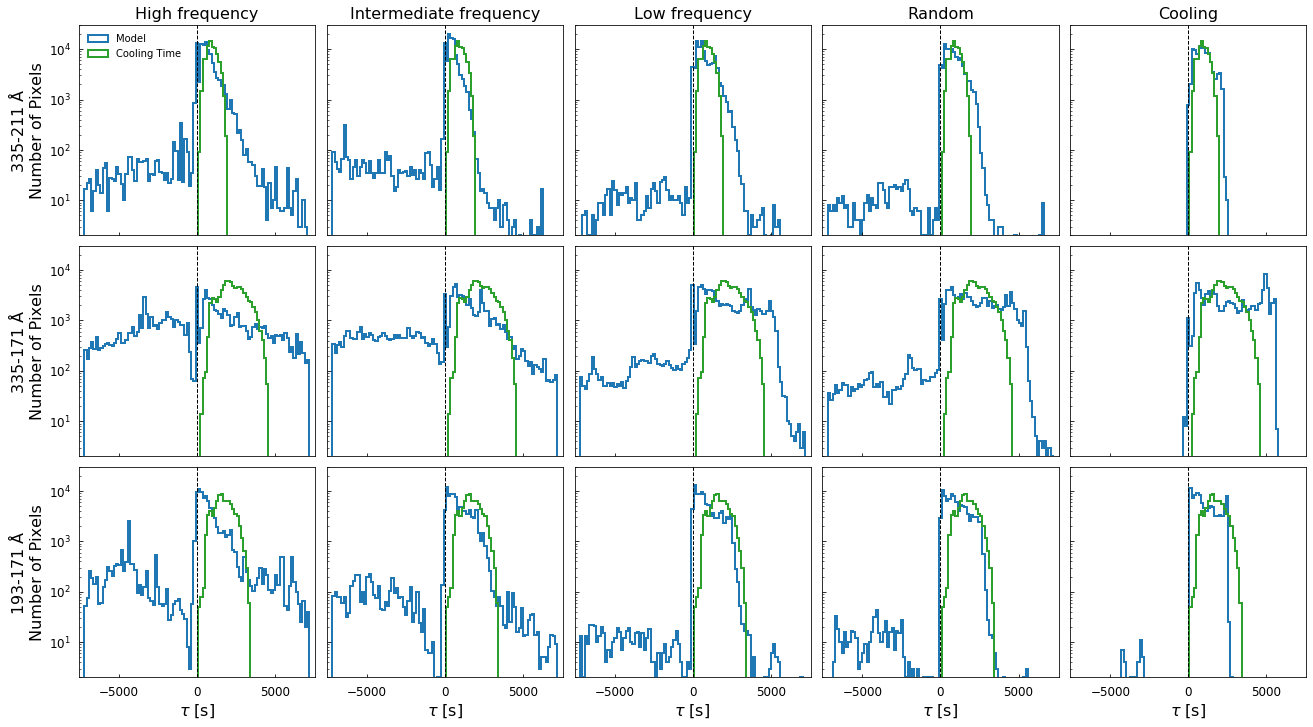

In [520]:
bins = np.linspace(-(2*u.hour).to(u.s).value, (2*u.hour).to(u.s).value, 100)
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'normed':False,'cumulative':False}
fig,axes = plt.subplots(3,5,figsize=(22,12),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for j,h in enumerate(['high_frequency','intermediate_frequency','low_frequency','cooling_outofphase','cooling',]):
    for i,cp in enumerate(channel_pairs[2:5]):
        ax = axes[i,j]
        m_tl = Map('../data/timelag_{}_{}-{}.fits'.format(h,*cp))
        m_c = Map('../data/correlation_{}_{}-{}.fits'.format(h,*cp))
        data = m_tl.data.flatten()
        data_cor = m_c.data.flatten()
        dist = data[np.where(data_cor >= 500.)]
        ax.hist(dist, **params, color='C0',ls='-',label='Model')
        m_loop_cooling = cooling_time_maps['{}-{}'.format(*cp)].data.flatten()
        m_loop_cooling = m_loop_cooling[~np.isnan(m_loop_cooling)]
        ax.hist(m_loop_cooling,**params,color='C2',ls='-',label='Cooling Time');
        ax.axvline(x=0,ls='--',color='k',lw=1)
        ax.tick_params(axis='both',which='both',direction='in')
        if j == 0:
            ax.set_ylabel(f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$\nNumber of Pixels')
        if i == 2:
            ax.set_xlabel(r'$\tau$ [s]')
        if i == 0:
            title_lab = 'Random' if h=='cooling_outofphase' else ' '.join(h.split('_')).capitalize()
            ax.set_title(title_lab)
        if i == 0 and j == 0:
            ax.legend(loc=2,frameon=False)
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_ylim(2,3e4);
fig.savefig('../img/timelag_distributions_plus_cooling_times.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

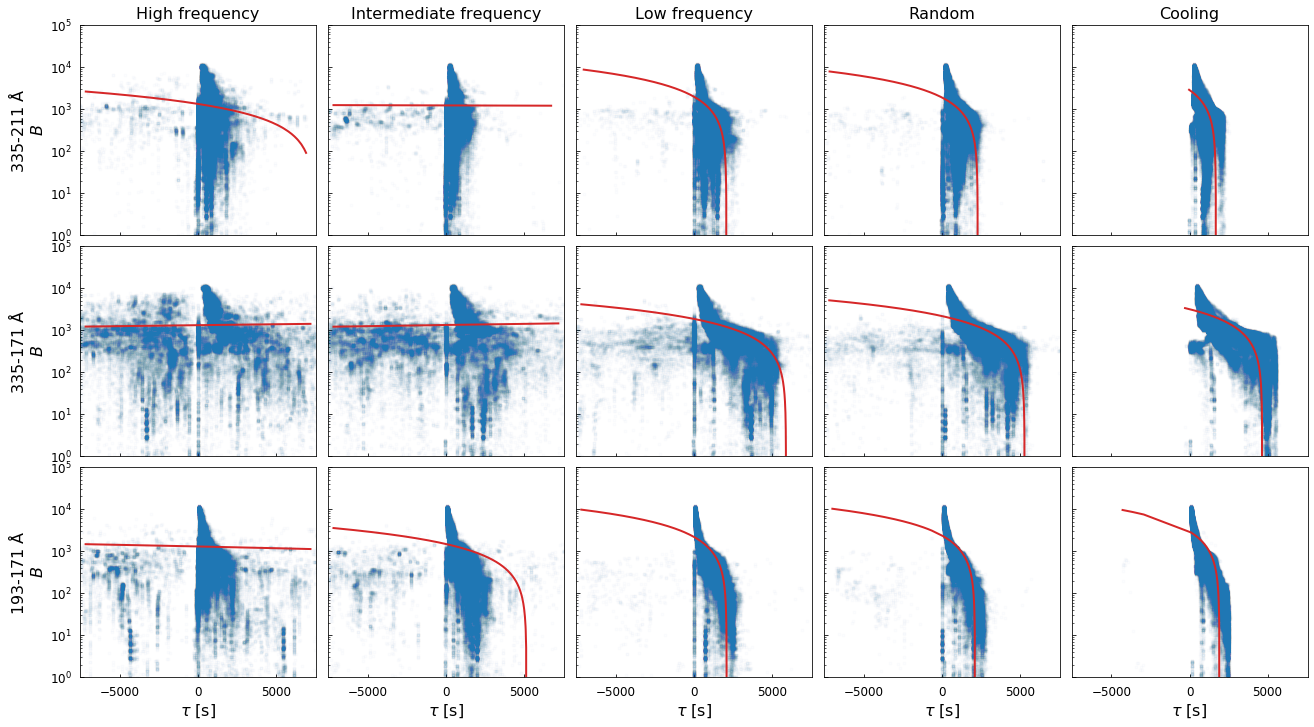

In [400]:
fig,axes = plt.subplots(3,5,figsize=(22,12),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
for j,h in enumerate(['high_frequency','intermediate_frequency','low_frequency','cooling_outofphase','cooling',]):
    for i,cp in enumerate(channel_pairs[2:5]):
        ax = axes[i,j]
        m_tl = Map('../data/timelag_{}_{}-{}.fits'.format(h,*cp))
        m_c = Map('../data/correlation_{}_{}-{}.fits'.format(h,*cp))
        data = m_tl.data.flatten()
        data_cor = m_c.data.flatten()
        data = data[np.where(data_cor >= 500.)]
        ax.tick_params(axis='both',which='both',direction='in')
        data_b = field_strength_map.data.flatten()[np.where(data_cor >= 500.)]
        ax.plot(data,data_b**2,marker='.',ls='',alpha=0.01,color='C0')
        # Fit a line
        mod = astropy.modeling.models.Linear1D(slope=-1,intercept=1e5)
        fitter = astropy.modeling.fitting.LinearLSQFitter()
        x = np.sort(data)
        y = (data_b**2)[np.argsort(data)]
        y = y[np.where(np.logical_and(x<=(2.*u.hour).to(u.s).value,
                                      x>=(-2*u.hour).to(u.s).value))]
        x = x[np.where(np.logical_and(x<=(2.*u.hour).to(u.s).value,
                                      x>=(-2*u.hour).to(u.s).value))]
        fit = fitter(mod,x,y)
        ax.plot(x,fit(x),ls='-',color='C3')
        if j == 0:
            ax.set_ylabel(f'{cp[0]}-{cp[1]} $\mathrm{{\AA}}$\n$B$')
        if i == 2:
            ax.set_xlabel(r'$\tau$ [s]')
        if i == 0:
            title_lab = 'Random' if h=='cooling_outofphase' else ' '.join(h.split('_')).capitalize()
            ax.set_title(title_lab)
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(1,1e5);
#axes[0,0].set_xscale('symlog',lin)